
--- Loading Data ---
Reference: right_wrist_template_10_trails_demo.xlsx
Patient:   right_arm_motion_Eigth Tracing_realsense_perfect 8.xlsx
PATIENT VIEW -> SCORE: 74.66/100
THERAPIST VIEW -> ANALYTICS:
RANGE OF MOTION (ROM)
  > Global Grade: 5 / 10
  > Avg Ratio:    77.3% of Reference
  > Axis Breakdown:
    X: 73% (Grade: 8)
    Y: 33% (Grade: 0)
    Z: 126% (Grade: 8)
  > STATUS: RESTRICTED (Too Small)

SHAPE QUALITY (RMSE)
  > Grade:        8 / 10
  > Global Error: 0.097 m
  > Limit:        < 0.200 m
  > Axis Error Breakdown:
    X: 0.054m
    Y: 0.069m
    Z: 0.043m
  > STATUS: GOOD SHAPE MATCH


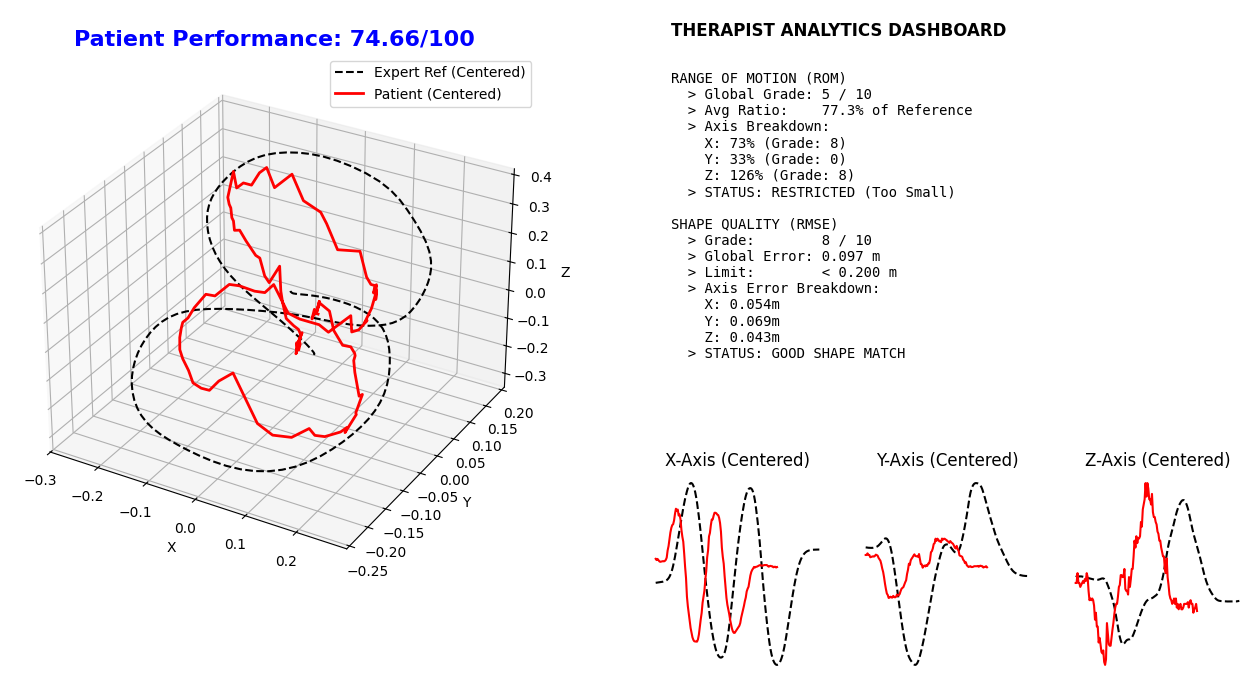

In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tslearn.metrics import dtw_path

# --- DATA EXTRACTION & UTILS ---

def add_awgn(data, std_dev=0.01):
    """Adds Additive White Gaussian Noise to simulate tremor/sensor jitter."""
    noise = np.random.normal(0, std_dev, data.shape)
    return data + noise

def get_arm_side(filename):
    """Detects arm side from filename (L/R)."""
    if "(L)" in filename.upper(): return "Left"
    return "Right"

def extract_hand_data(file_path):
    """Extracts Hand x, y, z data from Segment Position sheet."""
    side = get_arm_side(os.path.basename(file_path))
    try:
        df = pd.read_excel(file_path)
    except:
        df = pd.read_csv(file_path)
    
    possible_cols = [
        [f"{side} Hand x", f"{side} Hand y", f"{side} Hand z"], # Xsens standard
        [f"Wrist_x", f"Wrist_y", f"Wrist_z"],                   # MediaPipe standard
        [f"x", f"y", f"z"]                                      # Generic
    ]
    
    selected_cols = None
    for cols in possible_cols:
        if all(col in df.columns for col in cols):
            selected_cols = cols
            break
            
    if selected_cols is None:
        raise KeyError(f"Could not find valid X,Y,Z columns in {os.path.basename(file_path)}")
        
    return df[selected_cols].dropna().values

# --- CORE ALGORITHMS ---

def calculate_rom_metrics(ref_data, pat_data):
    """
    Computes Range of Motion (ROM) metrics and Grade.
    """
    # Calculate Range (Peak-to-Peak) for X, Y, Z
    ref_range = np.ptp(ref_data, axis=0)
    pat_range = np.ptp(pat_data, axis=0)
    
    # Avoid division by zero
    ref_range[ref_range == 0] = 1e-6
    
    # Calculate Ratio (Patient / Expert)
    ratios = pat_range / ref_range
    avg_rom_ratio = np.mean(ratios)
    
    return avg_rom_ratio, ratios

def get_rom_grade(ratio):
    """
    Maps a SINGLE ROM Ratio to a Simplified 0, 7-10 clinical grade.
    """
    # 1. FAIL CONDITIONS (Too small or Too big)
    if ratio < 0.50 or ratio > 1.50:
        return 0
        
    # 2. PERFECT RANGE (10/10)
    if 0.95 <= ratio <= 1.05:
        return 10
        
    # 3. UNDERSHOOTING (Small)
    if ratio < 0.95:
        if ratio >= 0.90: return 9
        elif ratio >= 0.70: return 8 # Broad range for "Okay"
        else: return 7 # 0.50 to 0.69 is "Acceptable/7"
        
    # 4. OVERSHOOTING (Large)
    if ratio > 1.05:
        if ratio <= 1.10: return 9
        elif ratio <= 1.30: return 8
        else: return 7 # 1.31 to 1.50 is "Acceptable/7"

def get_shape_grade(rmse, limit):
    """
    Maps the RMSE (Shape Error) to a 0, 6-10 clinical grade.
    """
    if rmse > limit:
        return 0
        
    step = limit / 5.0
    
    if rmse <= step: return 10
    elif rmse <= step * 2: return 9
    elif rmse <= step * 3: return 8
    elif rmse <= step * 4: return 7
    else: return 6

def calculate_mdtw_with_sensitivity(template, query, sensitivity=3.0, radius=10):
    """
    Computes mDTW metrics (Global RMSE + Per-Axis RMSE) and Score.
    """
    # 1. Mean-Centering ONLY
    template_centered = template - np.mean(template, axis=0)
    query_centered = query - np.mean(query, axis=0)
    
    # 2. Compute mDTW path
    optimal_path, sim_dist = dtw_path(template_centered, query_centered, 
                                      global_constraint="sakoe_chiba", 
                                      sakoe_chiba_radius=radius)
    
    # 3. Calculate Global RMSE (3D)
    path_length = len(optimal_path)
    global_rmse = sim_dist / np.sqrt(path_length)
    
    # 4. Calculate Per-Axis RMSE along the warped path
    sq_err_x, sq_err_y, sq_err_z = 0, 0, 0
    
    for (i, j) in optimal_path:
        sq_err_x += (template_centered[i, 0] - query_centered[j, 0])**2
        sq_err_y += (template_centered[i, 1] - query_centered[j, 1])**2
        sq_err_z += (template_centered[i, 2] - query_centered[j, 2])**2
        
    rmse_x = np.sqrt(sq_err_x / path_length)
    rmse_y = np.sqrt(sq_err_y / path_length)
    rmse_z = np.sqrt(sq_err_z / path_length)
    
    # 5. Final Score (Patient Gamification View - Exponential Decay)
    final_score = 100 * np.exp(-sensitivity * global_rmse)
    
    return round(final_score, 2), global_rmse, (rmse_x, rmse_y, rmse_z), template_centered, query_centered

# --- DIAGNOSTICS & VISUALIZATION ---

def generate_therapist_report(rom_ratio, avg_rom_grade, rom_axis_grades, rom_ratios, 
                              global_rmse, shape_grade, axis_rmse, shape_limit):
    """
    Generates the backend analytics text.
    """
    report = []
    
    # 1. ROM Analysis
    report.append(f"RANGE OF MOTION (ROM)")
    report.append(f"  > Global Grade: {avg_rom_grade} / 10")
    report.append(f"  > Avg Ratio:    {rom_ratio*100:.1f}% of Reference")
    report.append(f"  > Axis Breakdown:")
    report.append(f"    X: {rom_ratios[0]*100:.0f}% (Grade: {rom_axis_grades[0]})")
    report.append(f"    Y: {rom_ratios[1]*100:.0f}% (Grade: {rom_axis_grades[1]})")
    report.append(f"    Z: {rom_ratios[2]*100:.0f}% (Grade: {rom_axis_grades[2]})")
    
    if avg_rom_grade == 0:
        if rom_ratio < 1.0: report.append("  > STATUS: CRITICAL FAIL (Too Small)")
        else: report.append("  > STATUS: CRITICAL FAIL (Too Large)")
    elif avg_rom_grade >= 9:
        report.append("  > STATUS: EXCELLENT ROM")
    elif rom_ratio < 0.90:
        report.append("  > STATUS: RESTRICTED (Too Small)")
    elif rom_ratio > 1.10:
        report.append("  > STATUS: EXCESSIVE (Too Large)")
    else:
        report.append("  > STATUS: ACCEPTABLE DEVIATION")
        
    # 2. Shape Analysis
    report.append(f"\nSHAPE QUALITY (RMSE)")
    report.append(f"  > Grade:        {shape_grade} / 10")
    report.append(f"  > Global Error: {global_rmse:.3f} m")
    report.append(f"  > Limit:        < {shape_limit:.3f} m")
    
    rmse_x, rmse_y, rmse_z = axis_rmse
    max_err = max(rmse_x, rmse_y, rmse_z)
    
    report.append(f"  > Axis Error Breakdown:")
    report.append(f"    X: {rmse_x:.3f}m")
    report.append(f"    Y: {rmse_y:.3f}m")
    report.append(f"    Z: {rmse_z:.3f}m")
    
    if shape_grade == 0:
        report.append("  > STATUS: INCORRECT SHAPE (Mismatch)")
        if max_err == rmse_x: report.append("    -> MAIN ISSUE: Horizontal Path (X)")
        elif max_err == rmse_y: report.append("    -> MAIN ISSUE: Vertical Path (Y)")
        else: report.append("    -> MAIN ISSUE: Depth Control (Z)")
    else:
         report.append("  > STATUS: GOOD SHAPE MATCH")
         
    return "\n".join(report)

def plot_comparison(ref_data, pat_data, score, report_text):
    """Plots 3D trajectory with side-panel for Therapist stats.
    NOTE: Input data should be mean-centered for accurate visual comparison.
    """
    fig = plt.figure(figsize=(15, 8)) 
    
    # Plot 1: 3D Trajectory
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot(ref_data[:,0], ref_data[:,1], ref_data[:,2], 'k--', label='Expert Ref (Centered)')
    ax1.plot(pat_data[:,0], pat_data[:,1], pat_data[:,2], 'r', linewidth=2, label='Patient (Centered)')
    ax1.set_title(f"Patient Performance: {score}/100", fontsize=16, fontweight='bold', color='blue')
    ax1.legend()
    ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
    
    # Plot 2: Therapist Dashboard (Text)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.axis('off')
    ax2.text(0.05, 0.98, "THERAPIST ANALYTICS DASHBOARD", fontsize=12, fontweight='bold', va='top')
    ax2.text(0.05, 0.90, report_text, fontsize=10, family='monospace', va='top')
    
    # Add coordinate variation plots below text
    ax_x = fig.add_axes([0.55, 0.05, 0.12, 0.25])
    ax_x.plot(ref_data[:,0], 'k--'); ax_x.plot(pat_data[:,0], 'r')
    ax_x.set_title("X-Axis (Centered)")
    ax_x.axis('off')
    
    ax_y = fig.add_axes([0.69, 0.05, 0.12, 0.25])
    ax_y.plot(ref_data[:,1], 'k--'); ax_y.plot(pat_data[:,1], 'r')
    ax_y.set_title("Y-Axis (Centered)")
    ax_y.axis('off')

    ax_z = fig.add_axes([0.83, 0.05, 0.12, 0.25])
    ax_z.plot(ref_data[:,2], 'k--'); ax_z.plot(pat_data[:,2], 'r')
    ax_z.set_title("Z-Axis (Centered)")
    ax_z.axis('off')

    plt.show()

def run_analysis(ref_path, pat_path, sensitivity=3.0, noise_level=0.0, shape_limit_m=0.10):
    print(f"\n--- Loading Data ---")
    ref_data = extract_hand_data(ref_path)
    pat_data = extract_hand_data(pat_path)
    
    if noise_level > 0:
        pat_data = add_awgn(pat_data, noise_level)
    
    # 1. Compute Analytics
    # Extracted centered templates for plotting
    score, global_rmse, axis_rmse, temp_cen, query_cen = calculate_mdtw_with_sensitivity(ref_data, pat_data, sensitivity)
    rom_ratio, rom_ratios = calculate_rom_metrics(ref_data, pat_data)
    
    # 2. Per-Axis Grading Logic
    rom_axis_grades = [get_rom_grade(r) for r in rom_ratios] 
    avg_rom_grade = int(round(np.mean(rom_axis_grades))) # Rounded to nearest integer
    
    shape_grade = get_shape_grade(global_rmse, shape_limit_m)
    
    # 3. Generate Report
    report = generate_therapist_report(rom_ratio, avg_rom_grade, rom_axis_grades, rom_ratios, 
                                       global_rmse, shape_grade, axis_rmse, shape_limit_m)
    
    print(f"Reference: {os.path.basename(ref_path)}")
    print(f"Patient:   {os.path.basename(pat_path)}")
    print("="*50)
    print(f"PATIENT VIEW -> SCORE: {score}/100")
    print("="*50)
    print("THERAPIST VIEW -> ANALYTICS:")
    print(report)
    print("="*50)
    
    # Passing the CENTERED data to the plotter
    plot_comparison(temp_cen, query_cen, score, report)
    
    return score

if __name__ == "__main__":  
    # Update paths
    REF = r"C:\Users\LOQ\Desktop\Uni Work\FYP\Depth Data\Reference Templates\right_wrist_template_10_trails_demo.xlsx"
    PAT = r"C:\Users\LOQ\Desktop\Uni Work\FYP\Depth Data\mmDTW Testing\right_arm_motion_Eigth Tracing_realsense_perfect 8.xlsx"
    
    # --- CONFIGURATION ---
    SENSITIVITY = 3.0
    
    # SHAPE LIMIT (e.g. 0.20 means 20cm allowed error)
    Shape_Tolerance = 0.20
    
    run_analysis(REF, PAT, sensitivity=SENSITIVITY, noise_level=0.0, shape_limit_m=Shape_Tolerance)